# Official source code of CLIPstyler

In [ ]:
#@title Download Packages
import os
import sys
import matplotlib.pyplot as plt
clipstyler_dir = os.path.join("/content", "clipstyler")

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!git clone https://github.com/paper11667/CLIPstyler/ $clipstyler_dir
sys.path.append(clipstyler_dir)

from PIL import Image
import numpy as np
import sys
import torch
import torch.nn
import torch.optim as optim
from torchvision import transforms, models

import StyleNet
import utils
import clip
import torch.nn.functional as F
from template import imagenet_templates

from PIL import Image
import PIL
from torchvision import utils as vutils
import argparse
from torchvision.transforms.functional import adjust_contrast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-__1zkmaa
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-__1zkmaa
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
#@title Functions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGG = models.vgg19(pretrained=True).features
VGG.to(device)

for parameter in VGG.parameters():
    parameter.requires_grad_(False)

def img_denormalize(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = image*std +mean
    return image

def img_normalize(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image

def clip_normalize(image,device):
    image = F.interpolate(image,size=224,mode='bicubic')
    mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(device)
    std=torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image


def get_image_prior_losses(inputs_jit):
    diff1 = inputs_jit[:, :, :, :-1] - inputs_jit[:, :, :, 1:]
    diff2 = inputs_jit[:, :, :-1, :] - inputs_jit[:, :, 1:, :]
    diff3 = inputs_jit[:, :, 1:, :-1] - inputs_jit[:, :, :-1, 1:]
    diff4 = inputs_jit[:, :, :-1, :-1] - inputs_jit[:, :, 1:, 1:]

    loss_var_l2 = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)

    return loss_var_l2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 71.6MB/s]


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 47.7MiB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


After 0 iters:
Total loss:  10372.763671875
Content loss:  7.6545820236206055
patch loss:  0.97314453125
dir loss:  0.9287109375
TV loss:  0.32630228996276855


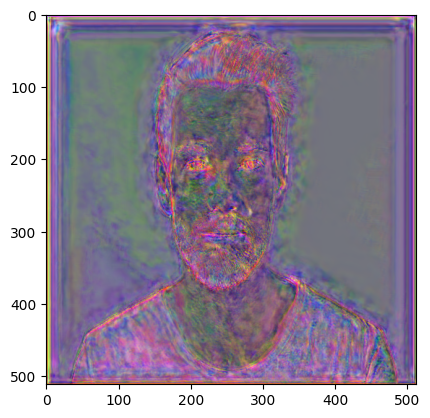

After 20 iters:
Total loss:  8986.6474609375
Content loss:  4.226176738739014
patch loss:  0.884765625
dir loss:  0.77685546875
TV loss:  0.22041186690330505


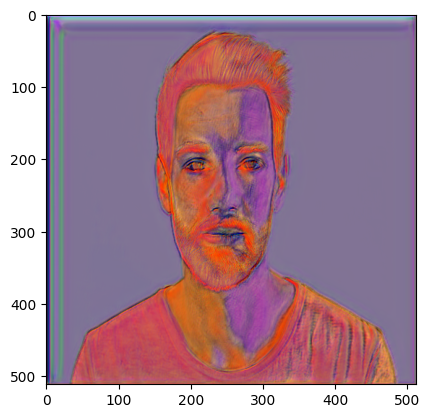

After 40 iters:
Total loss:  8670.1513671875
Content loss:  3.4643020629882812
patch loss:  0.8662109375
dir loss:  0.70849609375
TV loss:  0.255536288022995


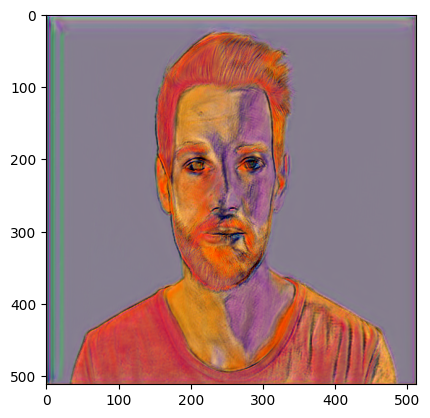

After 60 iters:
Total loss:  8405.255859375
Content loss:  3.0698587894439697
patch loss:  0.84521484375
dir loss:  0.6728515625
TV loss:  0.27671945095062256


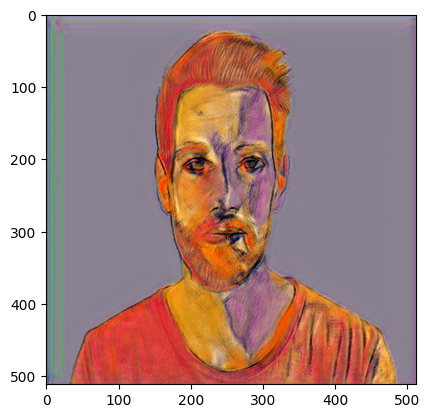

After 80 iters:
Total loss:  8262.828125
Content loss:  2.828547239303589
patch loss:  0.8349609375
dir loss:  0.64453125
TV loss:  0.2960784435272217


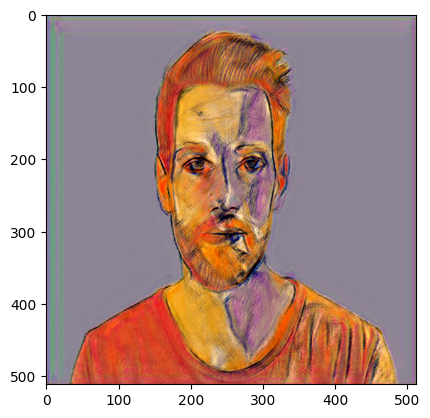

After 100 iters:
Total loss:  8158.36572265625
Content loss:  2.53696346282959
patch loss:  0.82958984375
dir loss:  0.619140625
TV loss:  0.32122957706451416


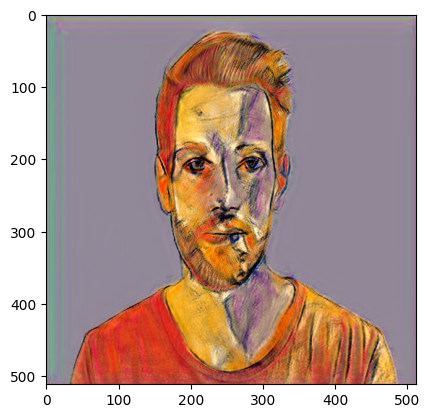

After 120 iters:
Total loss:  8145.14599609375
Content loss:  2.3504035472869873
patch loss:  0.83251953125
dir loss:  0.6005859375
TV loss:  0.33521711826324463


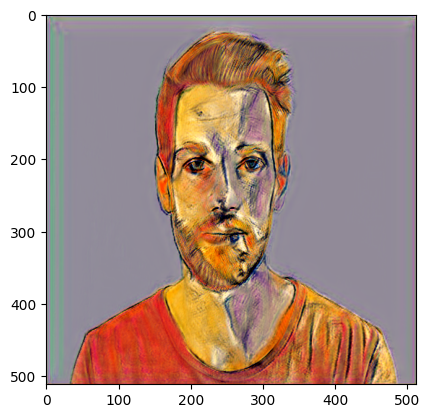

After 140 iters:
Total loss:  8180.0146484375
Content loss:  2.2561264038085938
patch loss:  0.8388671875
dir loss:  0.58642578125
TV loss:  0.34586504101753235


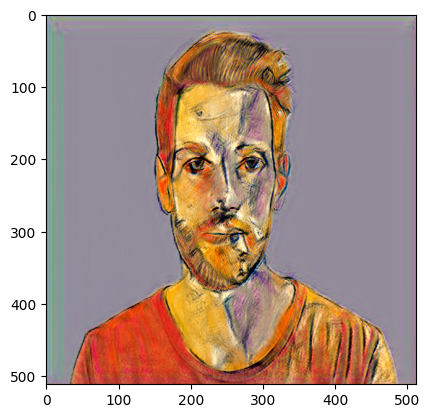

After 160 iters:
Total loss:  7995.23828125
Content loss:  2.155874490737915
patch loss:  0.8203125
dir loss:  0.5751953125
TV loss:  0.35686978697776794


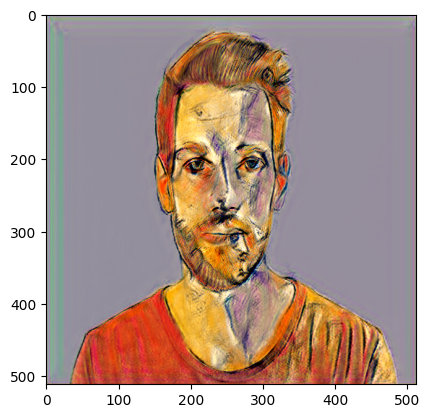

After 180 iters:
Total loss:  8005.27587890625
Content loss:  2.051039218902588
patch loss:  0.82421875
dir loss:  0.5625
TV loss:  0.37030932307243347


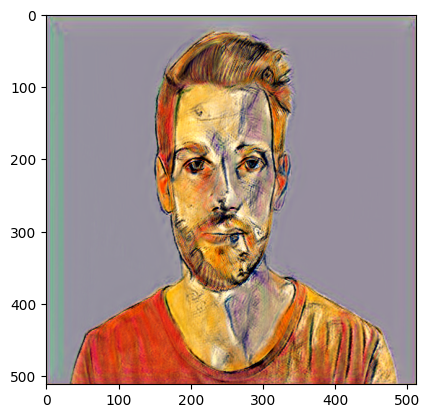

After 200 iters:
Total loss:  7911.34423828125
Content loss:  2.0080695152282715
patch loss:  0.814453125
dir loss:  0.5556640625
TV loss:  0.3838205933570862


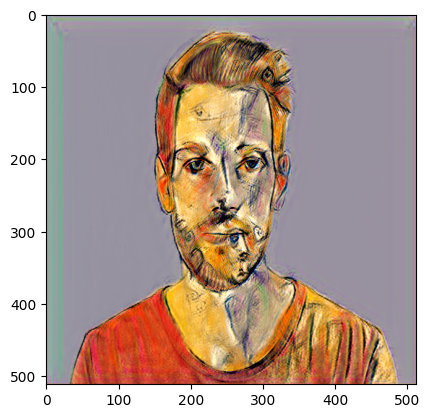

In [ ]:
from IPython.display import display
from argparse import Namespace

source = "a Photo"

text = "Sketch in picasso style" #@param {"type": "string"}
crop_size = 128 #@param {"type": "integer"}
image_dir = "Man.jpg" #@param {type: "string"}


training_iterations = 200 #@param {type: "integer"}


training_args = {
    "lambda_tv": 2e-3,
    "lambda_patch": 9000,
    "lambda_dir": 500,
    "lambda_c": 150,
    "crop_size": 128,
    "num_crops":64,
    "img_height":512,
    "img_width":512,
    "max_step":training_iterations,
    "lr":5e-4,
    "thresh":0.7,
    "content_path":image_dir,
    "text":text
}

args = Namespace(**training_args)

def compose_text_with_templates(text: str, templates=imagenet_templates) -> list:
    return [template.format(text) for template in templates]

content_path = args.content_path
content_image = utils.load_image2(content_path, img_height=args.img_height,img_width =args.img_width)

content_image = content_image.to(device)

content_features = utils.get_features(img_normalize(content_image), VGG)

target = content_image.clone().requires_grad_(True).to(device)

style_net = StyleNet.UNet()
style_net.to(device)

style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = args.lambda_c

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
steps = args.max_step

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []

output_image = content_image

m_cont = torch.mean(content_image,dim=(2,3),keepdim=False).squeeze(0)
m_cont = [m_cont[0].item(),m_cont[1].item(),m_cont[2].item()]

cropper = transforms.Compose([
    transforms.RandomCrop(args.crop_size)
])
augment = transforms.Compose([
    transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
    transforms.Resize(224)
])

clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

prompt = args.text

source = "a Photo"

with torch.no_grad():
    template_text = compose_text_with_templates(prompt, imagenet_templates)
    tokens = clip.tokenize(template_text).to(device)
    text_features = clip_model.encode_text(tokens).detach()
    text_features = text_features.mean(axis=0, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    template_source = compose_text_with_templates(source, imagenet_templates)
    tokens_source = clip.tokenize(template_source).to(device)
    text_source = clip_model.encode_text(tokens_source).detach()
    text_source = text_source.mean(axis=0, keepdim=True)
    text_source /= text_source.norm(dim=-1, keepdim=True)
    source_features = clip_model.encode_image(clip_normalize(content_image,device))
    source_features /= (source_features.clone().norm(dim=-1, keepdim=True))


num_crops = args.num_crops
for epoch in range(0, steps+1):

    scheduler.step()
    target = style_net(content_image,use_sigmoid=True).to(device)
    target.requires_grad_(True)

    target_features = utils.get_features(img_normalize(target), VGG)

    content_loss = 0

    content_loss += torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    content_loss += torch.mean((target_features['conv5_2'] - content_features['conv5_2']) ** 2)

    loss_patch=0
    img_proc =[]
    for n in range(num_crops):
        target_crop = cropper(target)
        target_crop = augment(target_crop)
        img_proc.append(target_crop)

    img_proc = torch.cat(img_proc,dim=0)
    img_aug = img_proc

    image_features = clip_model.encode_image(clip_normalize(img_aug,device))
    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))

    img_direction = (image_features-source_features)
    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)

    text_direction = (text_features-text_source).repeat(image_features.size(0),1)
    text_direction /= text_direction.norm(dim=-1, keepdim=True)
    loss_temp = (1- torch.cosine_similarity(img_direction, text_direction, dim=1))
    loss_temp[loss_temp<args.thresh] =0
    loss_patch+=loss_temp.mean()

    glob_features = clip_model.encode_image(clip_normalize(target,device))
    glob_features /= (glob_features.clone().norm(dim=-1, keepdim=True))

    glob_direction = (glob_features-source_features)
    glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)

    loss_glob = (1- torch.cosine_similarity(glob_direction, text_direction, dim=1)).mean()

    reg_tv = args.lambda_tv*get_image_prior_losses(target)

    total_loss = args.lambda_patch*loss_patch + content_weight * content_loss+ reg_tv+ args.lambda_dir*loss_glob
    total_loss_epoch.append(total_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print("After %d iters:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('patch loss: ', loss_patch.item())
        print('dir loss: ', loss_glob.item())
        print('TV loss: ', reg_tv.item())

    if epoch %20 ==0:

        output_image = target.clone()
        output_image = torch.clamp(output_image,0,1)
        output_image = adjust_contrast(output_image,1.5)
        plt.imshow(utils.im_convert2(output_image))
        plt.show()


